## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from scipy.ndimage import convolve, affine_transform
from skimage.feature import peak_local_max

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'

## 3.1.1 Rotation, translation and scale

You should implement a function that takes two point sets as input and returns the rotation, translation, and scale. To ensure that you have the correct implementation, you can make a set of random 2D points and ensure that you get the correct numbers out. You can follow this procedure

**1. Generate a random 2D point set P**

**2. Define variables for translation t, rotation R, and scale s, and decide on their values**

**3. Transform P using these parameters to obtain the point set Q**

**4. Plot these point sets using two different colors**

**5. Implement a function**

    The function should compute the parameters t′, rotation R′, and scale s′ from P and Q. Make sure that you get the exact same values.

In [2]:
np.random.seed(0)
P = np.random.rand(2, 5)
print('Random numbers\n', P)

Random numbers
 [[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]]


In [3]:
t = np.array([0.5, 2]).reshape(-1, 1)

theta = np.pi / 4  # 45 degree rotation
R = np.array([[np.cos(theta), -np.sin(theta)], 
              [np.sin(theta),  np.cos(theta)]])

s = 0.5

print(f'The translational vector is\n{t}\n')
print(f'The rotational matrix is\n{R}\n')
print(f'The scaling factor is\n{s}\n')

The translational vector is
[[0.5]
 [2. ]]

The rotational matrix is
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

The scaling factor is
0.5



In [4]:
Q = s * R @ P + t
print('Transformed points\n', Q)

Transformed points
 [[0.46567682 0.59814718 0.39781967 0.35193906 0.51421754]
 [2.42239293 2.40756807 2.5283984  2.53335153 2.28535164]]


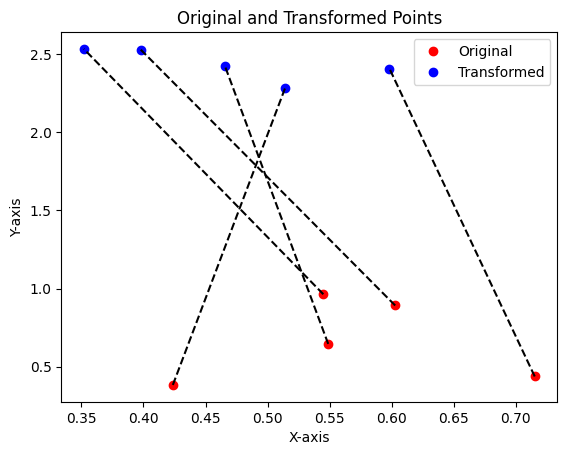

In [5]:
plt.figure()
plt.plot(P[0,:], P[1,:], 'ro', label='Original')
plt.plot(Q[0,:], Q[1,:], 'bo', label='Transformed')
plt.plot([P[0, :], Q[0, :]], [P[1, :], Q[1, :]], 'k--')

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Original and Transformed Points')
plt.show()

In [6]:
def Rotation_translation_scale(P, Q):
    """
    Calculate the rotation matrix, translation vector, and scaling factor 
    that transforms point set P to point set Q, considering both R and R.T.

    Parameters:
        P (numpy.ndarray): Original point set of shape (2, n)
        Q (numpy.ndarray): Transformed point set of shape (2, n)

    Returns:
        R (numpy.ndarray): Rotation matrix of shape (2, 2)
        t (numpy.ndarray): Translation vector of shape (2, 1)
        s (float): Scaling factor
    """
    
    # Calculate the scale
    mu_Q = np.mean(Q, axis=1).reshape(-1, 1) # mean of Q
    mu_P = np.mean(P, axis=1).reshape(-1, 1) # mean of P
    s = np.linalg.norm(Q - mu_Q) / np.linalg.norm(P - mu_P)

    # Calculate the rotation
    H = (Q - mu_Q) @ (P - mu_P).T
    U, _, Vt = np.linalg.svd(H)     # SVD decomposition and it will return the transpose of V therefore Vt
    R = Vt.T @ U.T
    R_T = R.T                       # Also consider the transpose of R

    # Calculate the translation for both rotations (this is done to ensure that we get the best rotational matrix)
    t = mu_Q - s * R @ mu_P
    t_T = mu_Q - s * R_T @ mu_P

    # Calculate the reconstructed points for both R and R_T
    Q_est = s * R @ P + t
    Q_est_T = s * R_T @ P + t_T

    # Calculate the reconstruction errors
    error_R = np.sum(np.linalg.norm(Q - Q_est, axis=0)**2)
    error_R_T = np.sum(np.linalg.norm(Q - Q_est_T, axis=0)**2)

    # Check determinant of R and R_T
    # Consider to add an abs value to allow for reflections
    assert np.isclose(np.linalg.det(R), 1.0, atol=1e-6), "Determinant of R is not 1, check for reflection or skew."
    assert np.isclose(np.linalg.det(R_T), 1.0, atol=1e-6), "Determinant of R_T is not 1, check for reflection or skew."

    # Choose the rotation with the minimum error
    if error_R <= error_R_T:
        return R, t, s
    else:
        return R_T, t_T, s


In [7]:
R_esti, t_esti, s_esti = Rotation_translation_scale(P, Q)

print(f'The estimated rotational matrix is\n{R_esti}\n')
print(f'The orginal rotational matrix is\n{R}\n')   
print(f'The estimated translational vector is\n{t_esti}\n')
print(f'The orginal translational vector is\n{t}\n')
print(f'The estimated scaling factor is\n{s_esti}\n')
print(f'The orginal scaling factor is\n{s}\n')  

print('Determinant of estimated R:', np.linalg.det(R_esti))


The estimated rotational matrix is
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

The orginal rotational matrix is
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

The estimated translational vector is
[[0.5]
 [2. ]]

The orginal translational vector is
[[0.5]
 [2. ]]

The estimated scaling factor is
0.5000000000000003

The orginal scaling factor is
0.5

Determinant of estimated R: 1.0000000000000002


In [8]:
np.random.seed(0)
Q_noisy = Q + 0.02 * np.random.randn(*Q.shape)
R_esti_noisy, t_esti_noisy, s_esti_noisy = Rotation_translation_scale(P, Q_noisy)

print(f'The estimated noisy rotational matrix is\n{R_esti_noisy}\n')
print(f'The orginal rotational matrix is\n{R}\n')   
print(f'The estimated noisy translational vector is\n{t_esti_noisy}\n')
print(f'The orginal translational vector is\n{t}\n')
print(f'The estimated noisy scaling factor is\n{s_esti_noisy}\n')
print(f'The orginal scaling factor is\n{s}\n')  

print('Determinant of estimated noisy R:', np.linalg.det(R_esti_noisy))
print(f'The original Q is\n{Q}\n')
print(f'The noisy Q is\n{Q_noisy}\n')

The estimated noisy rotational matrix is
[[ 0.67339362 -0.73928414]
 [ 0.73928414  0.67339362]]

The orginal rotational matrix is
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

The estimated noisy translational vector is
[[0.54592638]
 [2.02896565]]

The orginal translational vector is
[[0.5]
 [2. ]]

The estimated noisy scaling factor is
0.4695699022289363

The orginal scaling factor is
0.5

Determinant of estimated noisy R: 1.0000000000000004
The original Q is
[[0.46567682 0.59814718 0.39781967 0.35193906 0.51421754]
 [2.42239293 2.40756807 2.5283984  2.53335153 2.28535164]]

The noisy Q is
[[0.50095787 0.60615033 0.41739443 0.39675692 0.5515687 ]
 [2.40284737 2.42656984 2.52537126 2.53128716 2.29356361]]



## 3.1.2 Compute and match SIFT 

Here you should compute SIFT features in two images and match them using Euclidean distance between their descriptor vectors. You should
use the criterion by Lowe where a correct match is found, if the fraction between the closest feature vector and the second closest feature vector is less than a certain value, e.g. 0.6. There are functionality for matching features in both vlFeat and OpenCV that you can use. You can also implement your own matching function where you take e.g. scale and rotation into the matching criterion. You can follow this procedure.

**1. Create a transformed image**

    Do this by rotating, scaling, and cropping an image. We call the original image1 and the transformed image2.

**2. Compute SIFT features in the two images**

**3. Match the SIFT features**

    You can use the functionality for matching SIFT from vlFeat for MATLAB and OpenCV for Python.

**4. Display the match to see if the matching criterion is correct**

**5. Extract the coordinates of the matching keypoints**

**6. Use the function form before**

    Computing the rotation, translation, and scale from before to transform the set of key points found in image1 to the set of keypoints found in image2.

**7. Display image2 and plot the key points found in image2 and the transformed key points from image1**

**8. confirmed that the points match**

    you can try to match the CT-images of fibers at the three resolutions shown in Figure 3.1. Visualize the matching feature points by drawing lines between them e.g. as shown in Figure 3.2. This allows you to visually evaluate the matching.

Text(0.5, 1.0, 'Transformed Image')

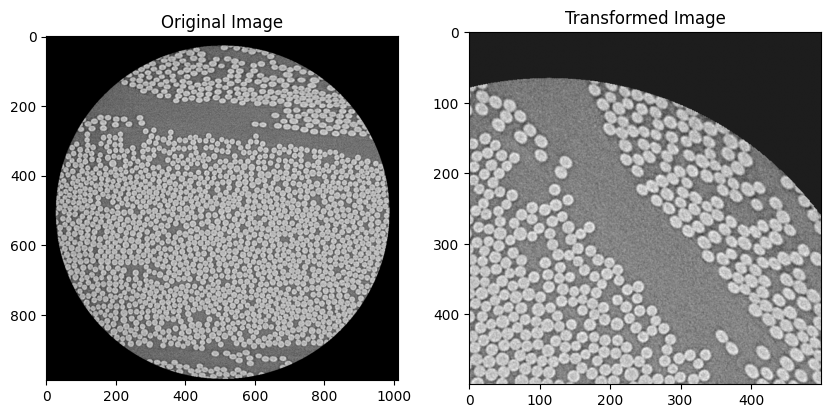

In [9]:
image1 = get_gray_image(PATH + 'CT_lab_high_res.png')

# Create the rotation matrix with respect to the center
theta = np.pi / 4                    # 45 degree rotation
R = np.array([[np.cos(theta), -np.sin(theta)], 
              [np.sin(theta),  np.cos(theta)]])

t = np.array([200, -100]).reshape(-1,1)

image2 = affine_transform(image1, np.hstack([R,t]))

# Scale the image
s = 1
image2 = s*image2 

# Crop the image
index = (100, 600)
image2 = image2[index[0]:index[1], index[0]:index[1]]

# Update the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image2, cmap='gray')
ax[1].set_title('Transformed Image')

Here are some notes for the SIFT class in python

SIFT first detects keypoints, which are distinctive points in an image that are invariant to scale, rotation, and illumination (light tensity)

Around each keypoint, SIFT computes a 128-dimensional feature vector (descriptor). This vector represents the local gradient distribution in a 16×16 region around the keypoint, divided into smaller 4×4 regions. Each of these 4×4 regions has an 8-bin orientation histogram, resulting in 4 × 4 × 8 = 128 values.

The 128-dimensional descriptor is normalized to improve robustness against changes in lighting and contrast.

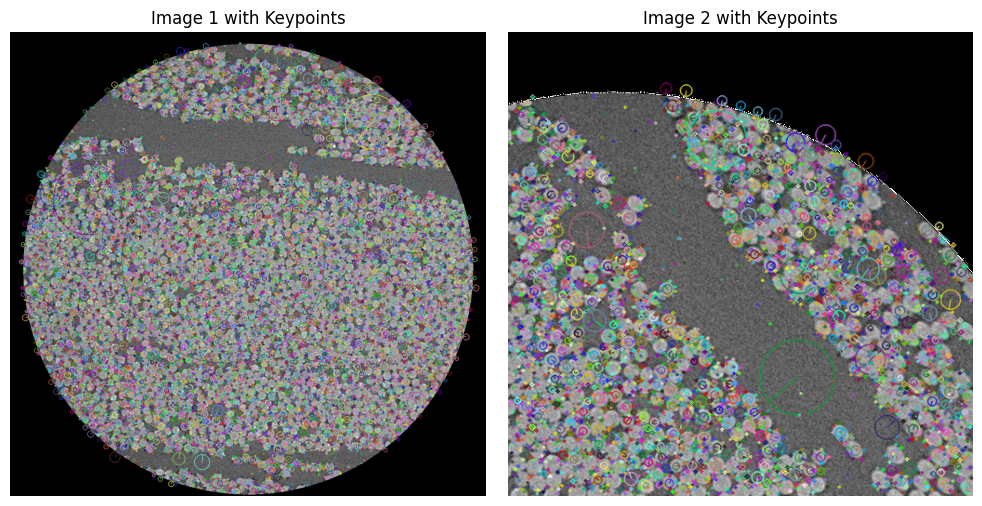

In [10]:
# The code below should be used when you want to load images 
""" 
img1 = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE) """

image1 = cv.cvtColor((image1 * 255).astype(np.uint8), cv.IMREAD_GRAYSCALE)
image2 = cv.cvtColor((image2 * 255).astype(np.uint8), cv.IMREAD_GRAYSCALE)

#  Detect SIFT features and compute descriptors
sift = cv.SIFT_create()

# Detect keypoints find them and compute descriptors
kp1, des1 = sift.detectAndCompute(image1, None) # None is used since we do not have a mask (kp = keypoints) and (des = descriptors which are 128-dimensional vectors) 
kp2, des2 = sift.detectAndCompute(image2, None) # None is used since we do not have a mask (kp = keypoints) and (des = descriptors which are 128-dimensional vectors)

# Draw the keypoints on the images with rich keypoints (which is keypoints with size and orientation)
image1_with_kp = cv.drawKeypoints(image1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.
image2_with_kp = cv.drawKeypoints(image2, kp2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS: For each keypoint, the circle around keypoint with keypoint size and orientation will be drawn.

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1_with_kp, cmap='gray')
ax[0].set_title('Image 1 with Keypoints')
ax[0].axis('off')
ax[1].imshow(image2_with_kp, cmap='gray')
ax[1].set_title('Image 2 with Keypoints')
ax[1].axis('off')
plt.tight_layout()
plt.show()

Lowe’s Ratio Test helps in removing false matches by ensuring that the best match is significantly better than the second-best match. This reduces mismatches caused by background noise or repetitive patterns.

In [11]:
def lowe_matches(des1, des2, lowe_threshold=0.6):
    """
    Apply Lowe's ratio test to filter good matches.

    Parameters:
        des1 (numpy.ndarray): Descriptors from the first image.
        des2 (numpy.ndarray): Descriptors from the second image.
        lowe_threshold (float): Threshold for Lowe's ratio test to filter good matches.

    Returns:
        good_matches (list): List of good matches after applying Lowe's ratio test.
    """
    
    # cv.BFMatcher: This is the brute-force matcher. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation.
    # cv.NORM_L2: This specifies that we use Euclidean distance (L2 norm) to measure similarity.
    # crossCheck=False: Allows one-way matching, meaning we consider all potential matches without requiring mutual agreement.
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

    # knnMatch() finds the two closest matches (best and second-best) for each descriptor in des1 from des2.
    matches = bf.knnMatch(des1, des2, k=2)        

    # Apply Lowe's ratio test to select good matches
    # m is the best match and n is the second best match to a given keypoint
    good_matches = []
    for m, n in matches:                            # m is the best match and n is the second best match
        if m.distance < lowe_threshold * n.distance:  # If the distance of the best match is less than the ratio times the distance of the second best match
            good_matches.append(m)   
    
    return good_matches

Number of good matches: 2768


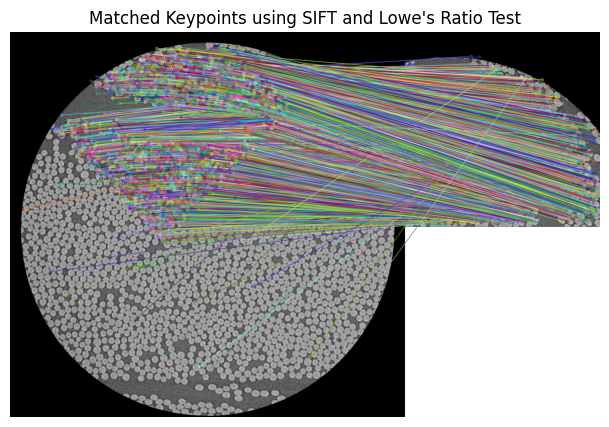

In [12]:
good_matches = lowe_matches(des1, des2, lowe_threshold=0.6)              

print(f"Number of good matches: {len(good_matches)}")

# Visualize the matches
matched_img = cv.drawMatches(image1, kp1, image2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.title("Matched Keypoints using SIFT and Lowe's Ratio Test")
plt.imshow(matched_img)
plt.axis('off')
plt.show()

In [13]:
# Extract the coordinates of the good matches
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = kp1[match.queryIdx].pt # gives the (x, y) coordinates of the keypoint in the first image
    points2[i, :] = kp2[match.trainIdx].pt # gives the (x, y) coordinates of the keypoint in the first image

print("Coordinates of good matches in image1:")
print(points1)

print("Coordinates of good matches in image2:")
print(points2)

Coordinates of good matches in image1:
[[ 33.933304 455.9664  ]
 [104.6499   614.54144 ]
 [108.04824  250.1538  ]
 ...
 [818.02673  556.1792  ]
 [898.02936  571.2188  ]
 [960.39453  613.17303 ]]
Coordinates of good matches in image2:
[[370.2644   143.94606 ]
 [187.6394   467.8647  ]
 [ 11.953383  82.355   ]
 ...
 [ 88.01064  453.88913 ]
 [108.77271  337.0267  ]
 [308.62454  119.39579 ]]


In [14]:
R_esti, t_esti, s_esti = Rotation_translation_scale(points1.T, points2.T)

print(f'The estimated rotational matrix is\n{R_esti}\n')
print(f'The rotational matrix is\n{R}\n')
print(f'The estimated translational vector is\n{t_esti}\n')
print(f'The translational vector is\n{t}\n')
print(f'The scaling factor is\n{s}\n')
print(f'The estimated scaling factor is\n{s_esti}\n')


The estimated rotational matrix is
[[ 0.7022882  -0.7118927 ]
 [ 0.7118927   0.70228815]]

The rotational matrix is
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

The estimated translational vector is
[[ 119.08444]
 [-162.66235]]

The translational vector is
[[ 200]
 [-100]]

The scaling factor is
1

The estimated scaling factor is
0.9775874614715576



Text(0.5, 1.0, 'Zoomed-in Keypoints')

c:\Users\madsp\anaconda3\envs\aia_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\madsp\anaconda3\envs\aia_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


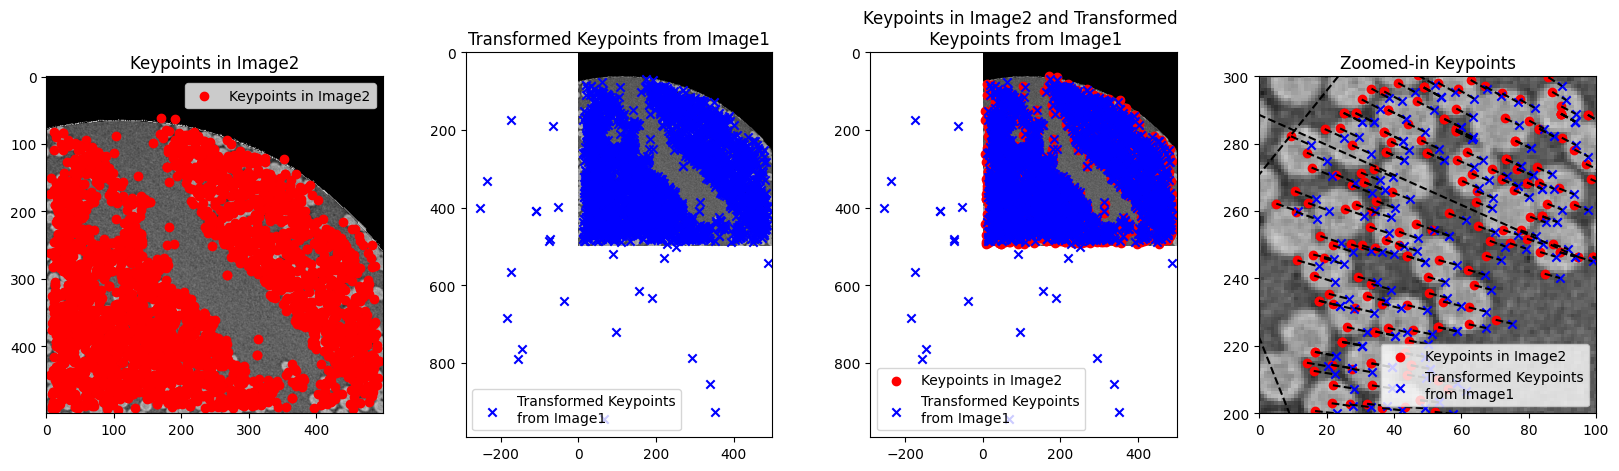

In [15]:
# Transform the key points from image1 using the estimated rotation, translation, and scale
transformed_points1 = s_esti * R_esti @ points1.T + t_esti
transformed_points1 = transformed_points1.T

# Plot image2 and the key points separately
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(image2, cmap='gray')
ax[0].scatter(points2[:, 0], points2[:, 1], c='r', marker='o', label='Keypoints in Image2')
ax[0].legend()
ax[0].set_title('Keypoints in Image2')

ax[1].imshow(image2, cmap='gray')
ax[1].scatter(transformed_points1[:, 0], transformed_points1[:, 1], c='b', marker='x', label='Transformed Keypoints\nfrom Image1')
ax[1].legend()
ax[1].set_title('Transformed Keypoints from Image1')

ax[2].imshow(image2, cmap='gray')
ax[2].scatter(points2[:, 0], points2[:, 1], c='r', marker='o', label='Keypoints in Image2')
ax[2].scatter(transformed_points1[:, 0], transformed_points1[:, 1], c='b', marker='x', label='Transformed Keypoints\nfrom Image1')
ax[2].legend()
ax[2].set_title('Keypoints in Image2 and Transformed \n Keypoints from Image1')

# Plot the zoomed-in keypoints in image2
ax[3].imshow(image2, cmap='gray')
ax[3].scatter(points2[:, 0], points2[:, 1], c='r', marker='o', label='Keypoints in Image2')
ax[3].scatter(transformed_points1[:, 0], transformed_points1[:, 1], c='b', marker='x', label='Transformed Keypoints\nfrom Image1')
ax[3].plot([points2[:, 0], transformed_points1[:, 0]], [points2[:, 1], transformed_points1[:, 1]], 'k--')
ax[3].set_xlim(0, 100)
ax[3].set_ylim(300, 200)
ax[3].invert_yaxis()
ax[3].legend()
ax[3].set_title('Zoomed-in Keypoints')


## Quiz

The quiz questions are about matching and transformation as described in the coursenote. Use the image ``quiz_image_1.png`` and the image ``quiz_image_2.png``. For matching, use Lowe criterion of 0.5. The first image contains points $p_i$ and the second points $q_i$. 

**1. What is the number of matched keypoints?**

In [16]:
def compute_sift_features(image1 = None, image2 = None, image1_path = None, image2_path = None, Lowe_threshold = 0.6):
    """
    Compute SIFT features for two images and match them using Lowe's ratio test.

    Parameters:
        image1 (numpy.ndarray): First image (grayscale) for SIFT feature detection.
        image2 (numpy.ndarray): Second image (grayscale) for SIFT feature detection.
        image1_path (str): Path to the first image file (if image1 is not provided).
        image2_path (str): Path to the second image file (if image2 is not provided).
        Lowe_threshold (float): Threshold for Lowe's ratio test to filter good matches.

    Returns:
        good_matches (list): List of good matches after applying Lowe's ratio test.
        matched_img (numpy.ndarray): Image showing the matched keypoints.
    """

    # Load the two images (grayscale)
    if image1_path is not None:
        image1 = cv.imread(image1_path, cv.IMREAD_GRAYSCALE)
    if image2_path is not None:
        image2 = cv.imread(image2_path, cv.IMREAD_GRAYSCALE) 
    

    if image1 is not None:
        image1 = cv.cvtColor((image1 * 255).astype(np.uint8), cv.IMREAD_GRAYSCALE)
    if image2 is not None:
        image2 = cv.cvtColor((image2 * 255).astype(np.uint8), cv.IMREAD_GRAYSCALE)

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(image1)
    ax[1].imshow(image2)
    print(f'Image1: min {np.min(image1)}, max: {np.max(image1)}')
    print(f'Image2: min {np.min(image2)}, max: {np.max(image2)}')
    
    #  Detect SIFT features and compute descriptors
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)     # None is used since we do not have a mask (kp = keypoints) and (des = descriptors which are 128-dimensional vectors) 
    kp2, des2 = sift.detectAndCompute(image2, None)     # None is used since we do not have a mask (kp = keypoints) and (des = descriptors which are 128-dimensional vectors)
    
    # Match features using BFMatcher with Euclidean distance
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)     # crossCheck=False means that we are not using the Lowe's Ratio Test
    matches = bf.knnMatch(des1, des2, k=2)              # Find the two nearest neighbors

    # Apply Lowe's Ratio Test
    good_matches = []
    for m, n in matches:                                # m is the best match and n is the second best match
        if m.distance < Lowe_threshold * n.distance:    # If the distance of the best match is less than the ratio times the distance of the second best match
            good_matches.append(m)                      # Then we have a good match

    # Visualize the matches
    matched_img = cv.drawMatches(image1, kp1, image2, kp2, good_matches, None, 
                                flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return good_matches, matched_img, kp1, kp2


Image1: min 0, max: 255
Image2: min 0, max: 255
Number of good matches: 375
Image1: min 0, max: 255
Image2: min 0, max: 255
Number of good matches: 360


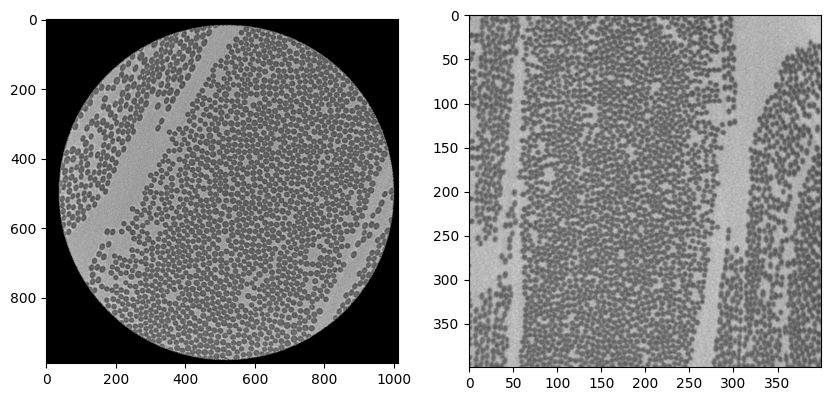

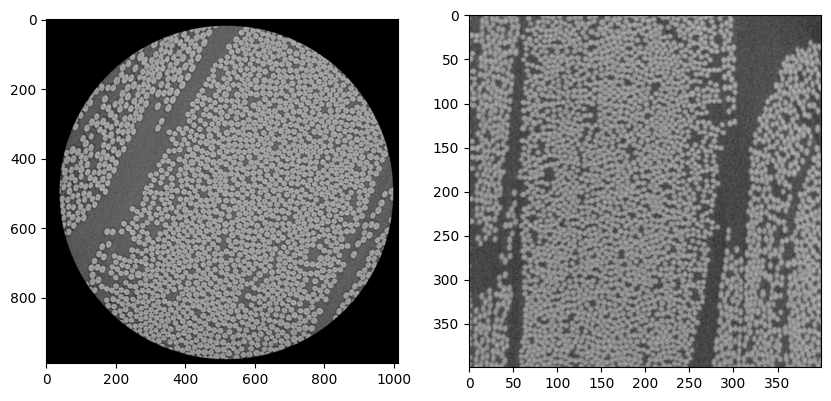

In [17]:
matches, matched_img, kp1, kp2  = compute_sift_features(image1_path=f'{PATH}quiz_image_1.png', image2_path=f'{PATH}quiz_image_2.png', Lowe_threshold=0.5)
print(f'Number of good matches: {len(matches)}')

image1 = get_gray_image(f'{PATH}quiz_image_1.png')
image2 = get_gray_image(f'{PATH}quiz_image_2.png')
matches, matched_img, kp1, kp2  = compute_sift_features(image1=image1, image2=image2, Lowe_threshold=0.5)
print(f'Number of good matches: {len(matches)}')


Image1: min 0, max: 255
Image2: min 0, max: 255
Number of good matches: 375


(np.float64(-0.5), np.float64(1412.5), np.float64(987.5), np.float64(-0.5))

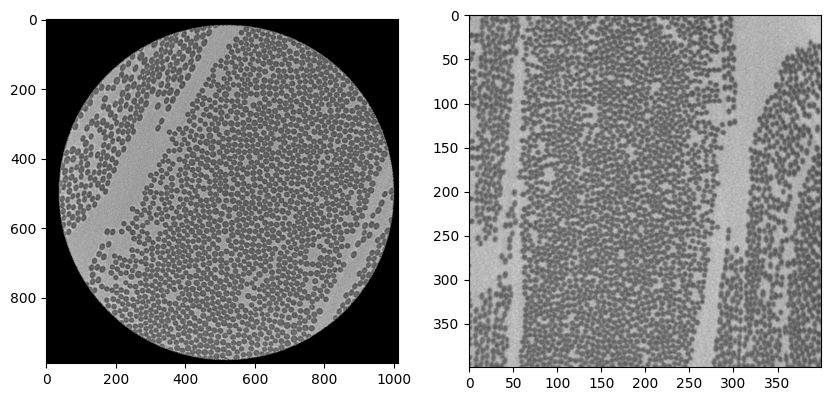

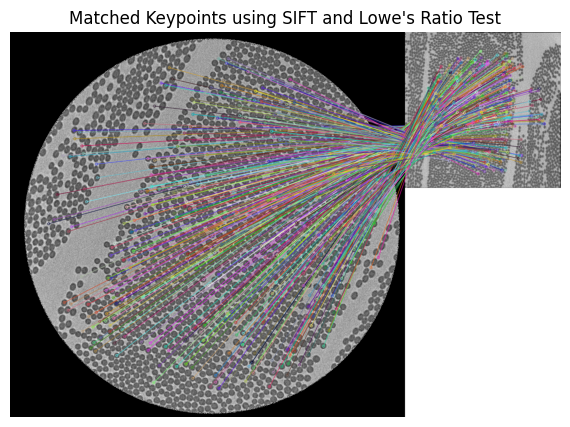

In [18]:
matches, matched_img, kp1, kp2  = compute_sift_features(image1_path=f'{PATH}quiz_image_1.png', image2_path=f'{PATH}quiz_image_2.png', Lowe_threshold=0.5)
print(f'Number of good matches: {len(matches)}')

plt.figure(figsize=(10, 5))
plt.title("Matched Keypoints using SIFT and Lowe's Ratio Test")
plt.imshow(matched_img)
plt.axis('off')

**2.  What is the scale?**

In [19]:
# Extract the coordinates of the good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

R_esti, t_esti, s_esti = Rotation_translation_scale(points1.T, points2.T)

print(f'The estimated rotational matrix is\n{R_esti}\n')
print(f'The estimated translational vector is\n{t_esti}\n')
print(f'The estimated scaling factor is\n{s_esti}\n')

The estimated rotational matrix is
[[-0.91985863 -0.39224997]
 [ 0.39224997 -0.91985863]]

The estimated translational vector is
[[448.511  ]
 [300.31943]]

The estimated scaling factor is
0.36853474378585815



**3.  What is the length of translation**

In [20]:
length = np.linalg.norm(t_esti)
print('The length of the translational vector is:', length)

The length of the translational vector is: 539.77203
